In [4]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np

from sktime.utils.plotting import plot_correlations

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,5)

### Примеры нестационарных рядов

In [12]:
beta_0 = 1
beta_1 = 0.5
sigma_sq = 16
n_steps = 1000

# Ряд с детерминированным трендом
y_det = [beta_0 + beta_1 * t + np.random.normal(scale=sigma_sq) for t in range(n_steps)]

# Ряд со стохастическим трендом
y_stoch = [0]
[y_stoch.append(beta_0 + y_stoch[-1] + np.random.normal(scale=sigma_sq)) for t in range(n_steps)]

y_det = pd.Series(y_det)
y_stoch = pd.Series(y_stoch)

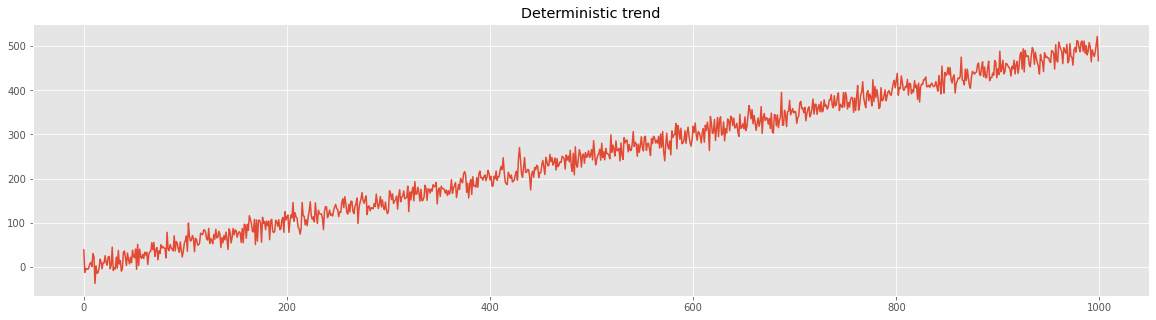

In [13]:
y_det.plot()
plt.title("Deterministic trend");

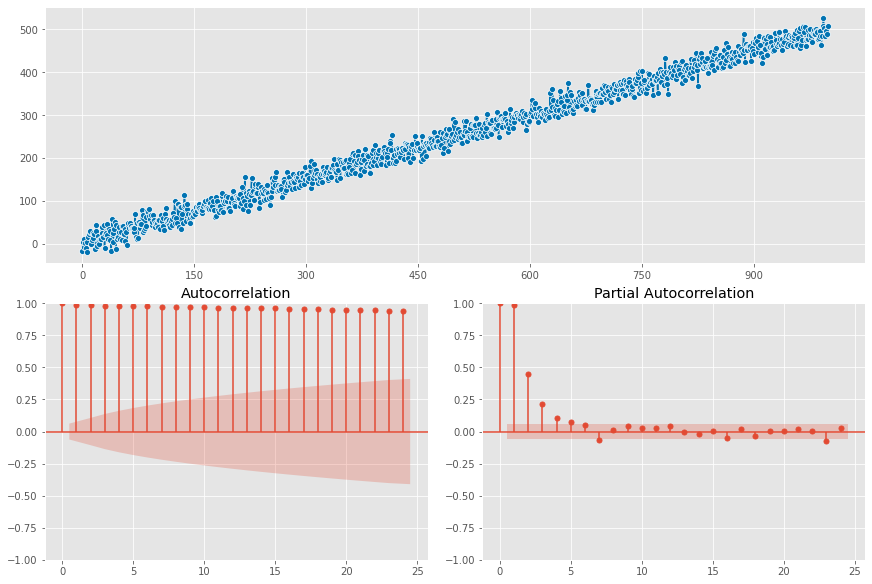

In [7]:
plot_correlations(y_det);

<AxesSubplot: >

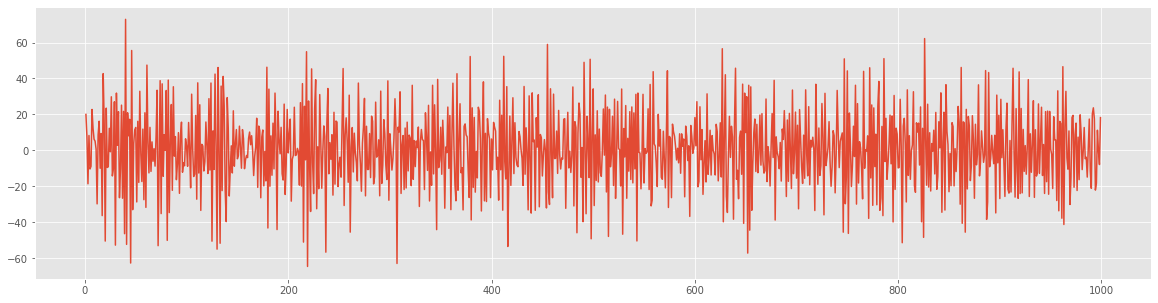

In [8]:
y_det.diff().dropna().plot()

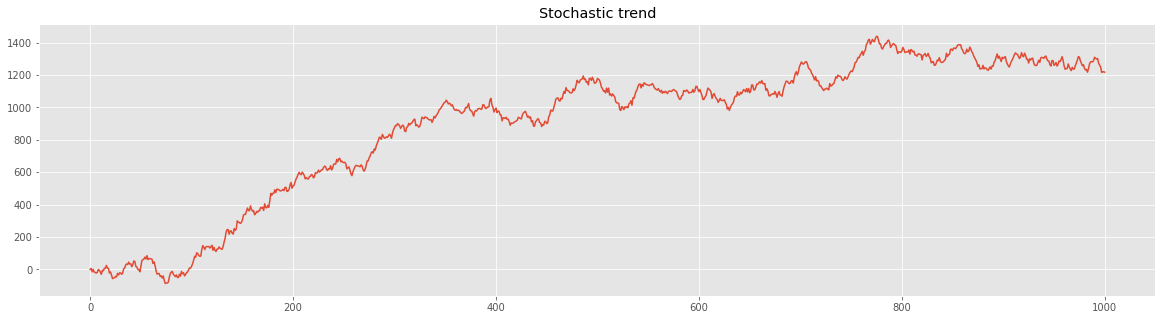

In [38]:
# Ряд со стохастическим трендом
y_stoch = [0]
[y_stoch.append(beta_0 + y_stoch[-1] + np.random.normal(scale=sigma_sq)) for t in range(n_steps)]

y_stoch = pd.Series(y_stoch)
y_stoch.plot()
plt.title("Stochastic trend");

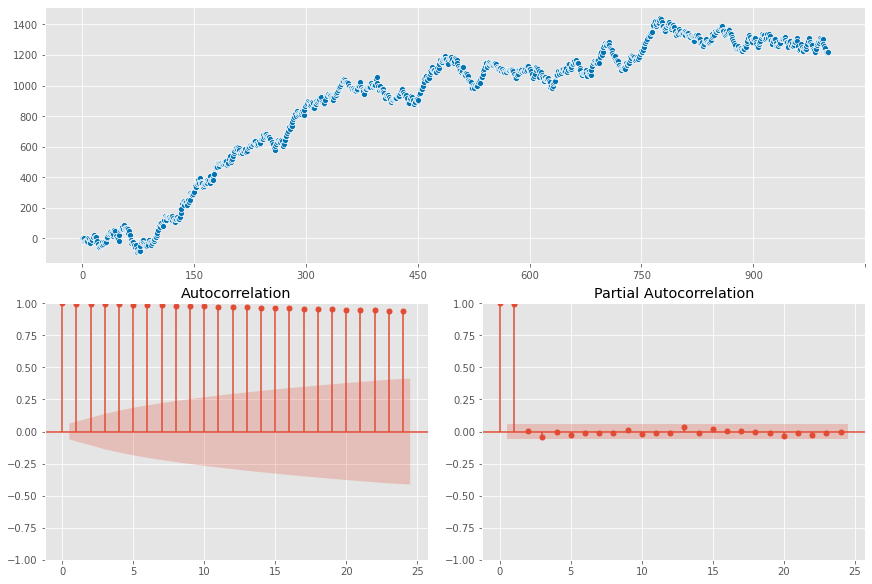

In [39]:
plot_correlations(y_stoch);


<AxesSubplot: >

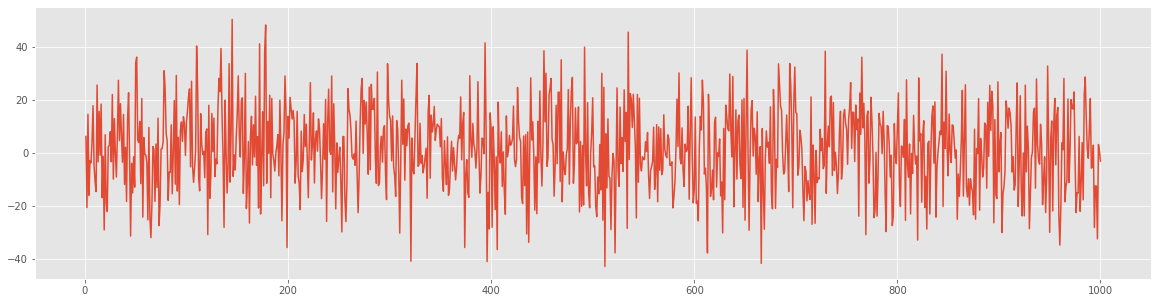

In [41]:
y_stoch.diff().dropna().plot()

Теперь посмотрим на какие-нибудь нестационарные процессы и попытаемся оценить на них ARIMA-модель.

In [42]:
import statsmodels.api as sm
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.model_selection import temporal_train_test_split

test_size = 20

data = sm.datasets.macrodata.load_pandas().data

realgdp = data['realgdp']

train, test = temporal_train_test_split(realgdp, test_size = test_size)

Возьмём какой-нибудь нестационарный ряд.

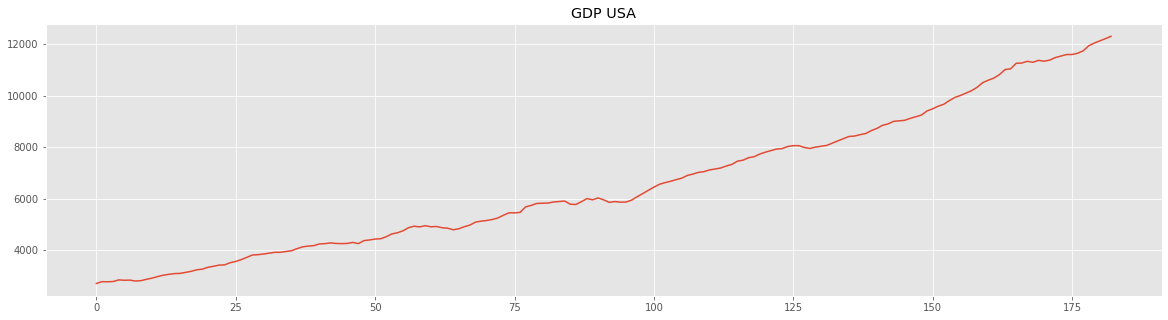

In [44]:
train.plot();
plt.title("GDP USA");

In [51]:
from statsmodels.tsa.stattools import kpss

# Гипотеза о стационарности отвергается
kpss(train)

C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(1.8785823835768833,
 0.01,
 9,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

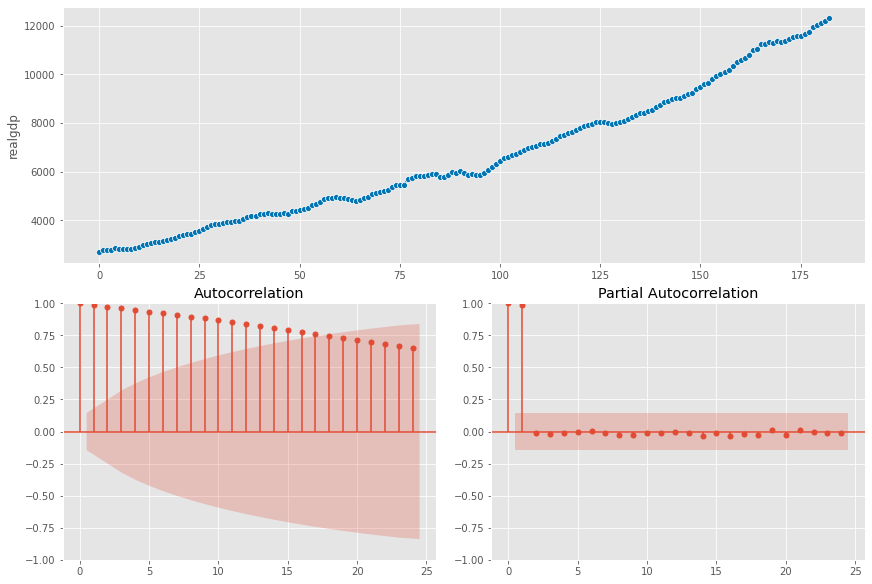

In [52]:
plot_correlations(train);

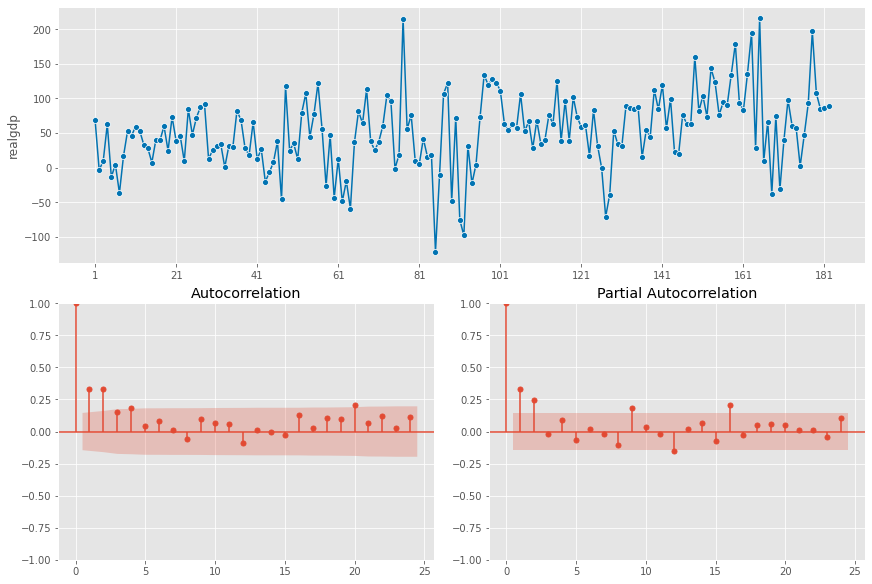

In [53]:
plot_correlations(train.diff().dropna());

In [54]:
# Гипотеза отвергается на 5-процентном уровне значимости. 
kpss(train.diff().dropna())

C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(0.8553755732183154,
 0.01,
 6,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

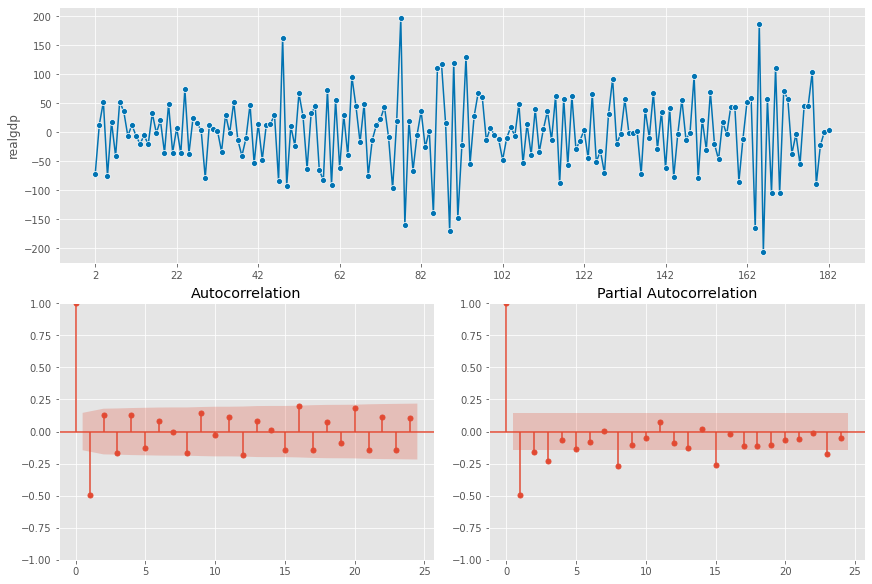

In [55]:
plot_correlations(train.diff().diff().dropna());

In [56]:
# Гипотеза не отвергается на 5-процентном уровне значимости. 
kpss(train.diff().diff().dropna())

C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.1852931960250787,
 0.1,
 55,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Ряд ВВП -- I(2)

In [57]:
from sktime.forecasting.base import ForecastingHorizon

# creating plot for forecast
# with lablels and title as params
def plot (pred, real):
    plt.plot(pred, label='Forecast')
    plt.plot(real, label='Real')
    plt.legend()
    plt.title('Forecast vs Real')
    plt.show()

In [59]:
test_size

20

In [60]:
max_p = 3
max_q = 1

orders = []

for p in range(max_p+1):
    for q in range(max_q+1):
        orders.append((p, 2, q))
        
fh = ForecastingHorizon(list(range(1, test_size+1)))


In [61]:
orders

[(0, 2, 0),
 (0, 2, 1),
 (1, 2, 0),
 (1, 2, 1),
 (2, 2, 0),
 (2, 2, 1),
 (3, 2, 0),
 (3, 2, 1)]

In [63]:
from sktime.forecasting.arima import AutoARIMA, ARIMA
from sktime.forecasting.model_selection import SlidingWindowSplitter, ForecastingGridSearchCV


cv = SlidingWindowSplitter(
    start_with_window=True,
    window_length=60,
    fh=fh,
    step_length=10
)

forecaster = ARIMA()
param_grid = {"order" : orders}

gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    cv=cv)

gscv.fit(train)
# pred = gscv.predict(fh)

C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\sktime\performance_metrics\forecasting\_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at

C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\sktime\performance_metrics\forecasting\_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of

C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\sktime\performance_metrics\forecasting\_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of

C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\sktime\performance_metrics\forecasting\_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. fore

C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\sktime\performance_metrics\forecasting\_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of

C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\sktime\performance_metrics\forecasting\_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\sktime\performance_metrics\forecasting\_classes.py:422: UserWarning: y_pred and y_true do no

C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\sktime\performance_metrics\forecasting\_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. fore

C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\sktime\performance_metrics\forecasting\_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. fore

C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\sktime\performance_metrics\forecasting\_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. fore

ForecastingGridSearchCV(cv=SlidingWindowSplitter(fh=ForecastingHorizon([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
            20],
           dtype='int64', is_relative=True),
                                                 step_length=10,
                                                 window_length=60),
                        forecaster=ARIMA(),
                        param_grid={'order': [(0, 2, 0), (0, 2, 1), (1, 2, 0),
                                              (1, 2, 1), (2, 2, 0), (2, 2, 1),
                                              (3, 2, 0), (3, 2, 1)]})

In [66]:
gscv.best_forecaster_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  183
Model:               SARIMAX(2, 2, 1)   Log Likelihood                -961.558
Date:                Mon, 06 Mar 2023   AIC                           1933.115
Time:                        20:05:23   BIC                           1949.108
Sample:                             0   HQIC                          1939.599
                                - 183                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1941      0.068      2.850      0.004       0.061       0.327
ar.L1          0.2084      0.074      2.828      0.005       0.064       0.353
ar.L2          0.2020      0.064      3.143      0.002       0.076       0.328
ma.L1         -0.9996      0.807     -1.238      0.216      -2.582       0.583
sigma2      2350.3124   1846.854      1.273      0.203   -1269.455    5970.079
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                13.33
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.94   Skew:                             0.06
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

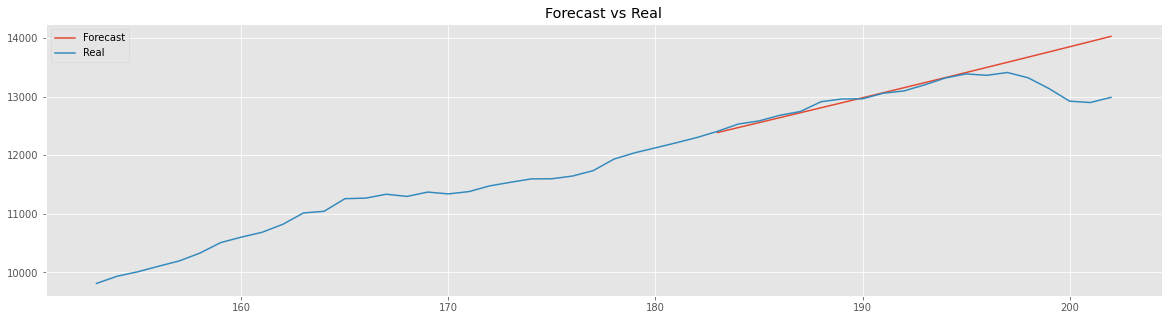

In [67]:
pred = gscv.predict(fh)

plot(pred, realgdp.tail(50))

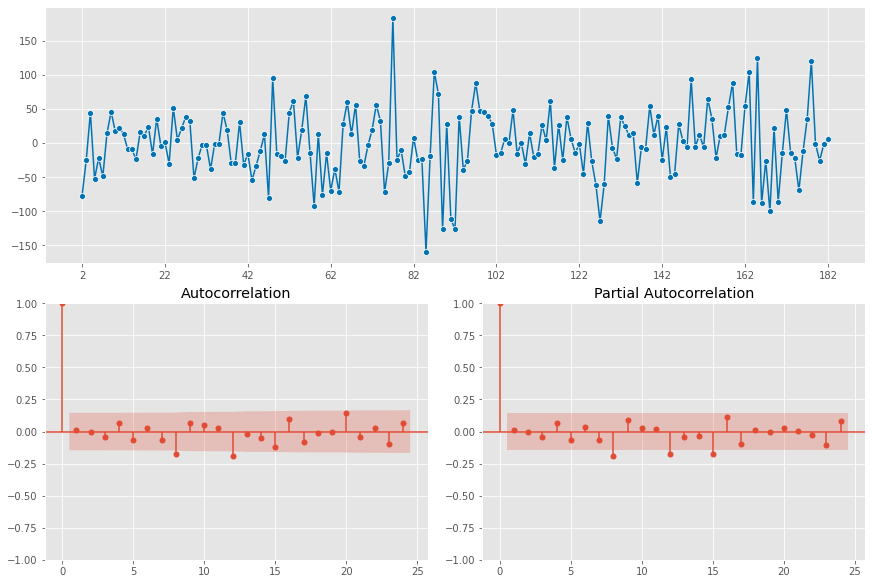

In [68]:
plot_correlations(gscv.predict_residuals().dropna());

C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parame

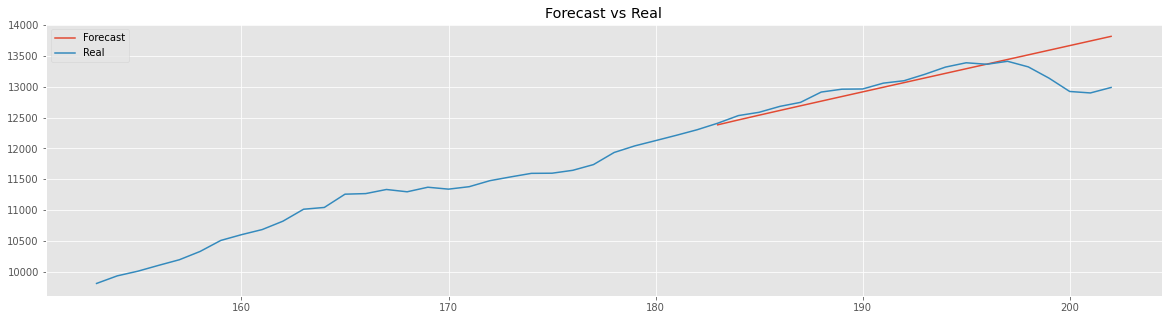

In [73]:
auto_model = AutoARIMA(start_p=0, start_q=0).fit(train)
auto_pred = auto_model.predict(fh)

plot(auto_pred, realgdp.tail(50))

In [72]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  183
Model:               SARIMAX(2, 2, 1)   Log Likelihood                -963.570
Date:                Mon, 06 Mar 2023   AIC                           1935.141
Time:                        20:08:53   BIC                           1947.935
Sample:                             0   HQIC                          1940.328
                                - 183                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2162      0.075      2.897      0.004       0.070       0.362
ar.L2          0.2095      0.063      3.331      0.001       0.086       0.333
ma.L1         -0.9704      0.021    -47.259      0.000      -1.011      -0.930
sigma2      2434.3431    202.668     12.011      0.000    2037.121    2831.565
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                11.46
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.98   Skew:                             0.10
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [125]:
brent = pd.read_excel('data/sem_7/brent.xlsx')
brent = brent.set_index('Date')
brent.index = pd.to_datetime(brent.index, format = "%d.%m.%Y")
brent.index = brent.index.to_period(freq="W-MON")
brent = brent.interpolate()

<AxesSubplot: xlabel='Date'>

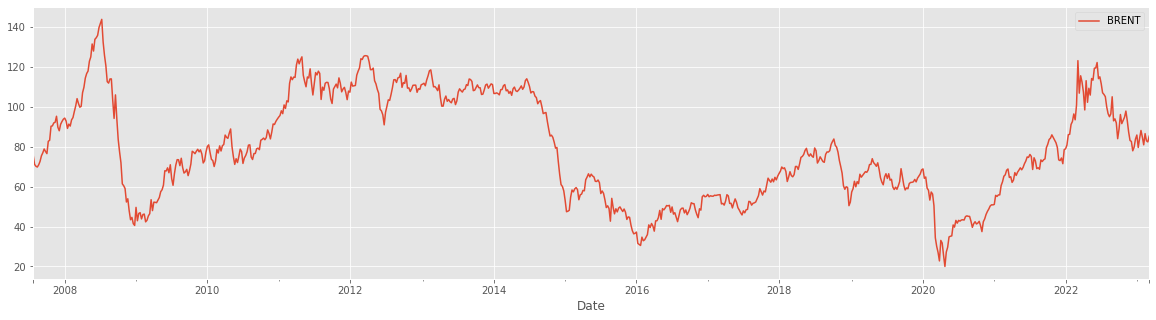

In [126]:
brent.plot()

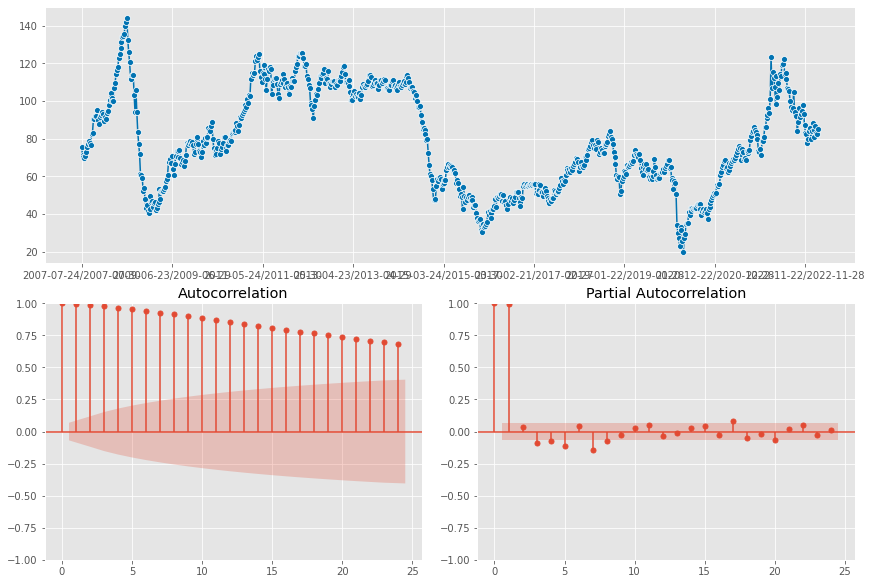

In [127]:
plot_correlations(brent);

In [128]:
kpss(brent)

C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(0.955251157862733,
 0.01,
 18,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot: >,
        <AxesSubplot: title={'center': 'Autocorrelation'}>,
        <AxesSubplot: title={'center': 'Partial Autocorrelation'}>],
       dtype=object))

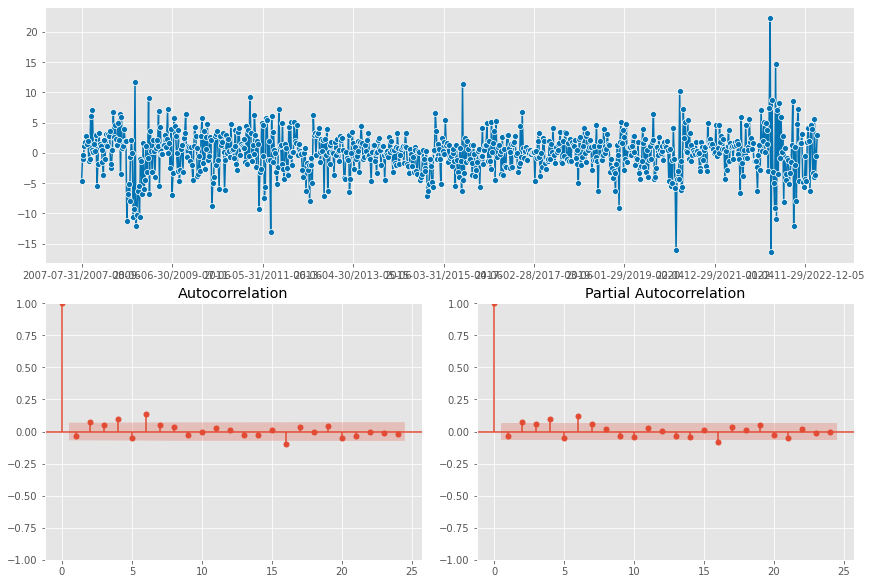

In [129]:
plot_correlations(brent.diff().dropna())

In [130]:
kpss(brent.diff().dropna())

C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.051494871250905766,
 0.1,
 10,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [131]:
train, test = temporal_train_test_split(brent, test_size=0.1)

In [132]:
auto_model = AutoARIMA(start_p=0, start_q=0).fit(train)

fh = ForecastingHorizon(list(range(1, len(test)+1)))
auto_pred = auto_model.predict(fh=fh)

C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\zehov\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. 

In [133]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  733
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1891.222
Date:                Mon, 06 Mar 2023   AIC                           3788.444
Time:                        20:25:48   BIC                           3802.231
Sample:                    07-30-2007   HQIC                          3793.762
                         - 08-09-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8631      0.068     12.773      0.000       0.731       0.996
ma.L1         -0.7952      0.083     -9.604      0.000      -0.957      -0.633
sigma2        10.2712      0.374     27.441      0.000       9.538      11.005
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):               159.79
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [144]:
brent.index = brent.index.to_timestamp()
auto_pred.index = auto_pred.index.to_timestamp()


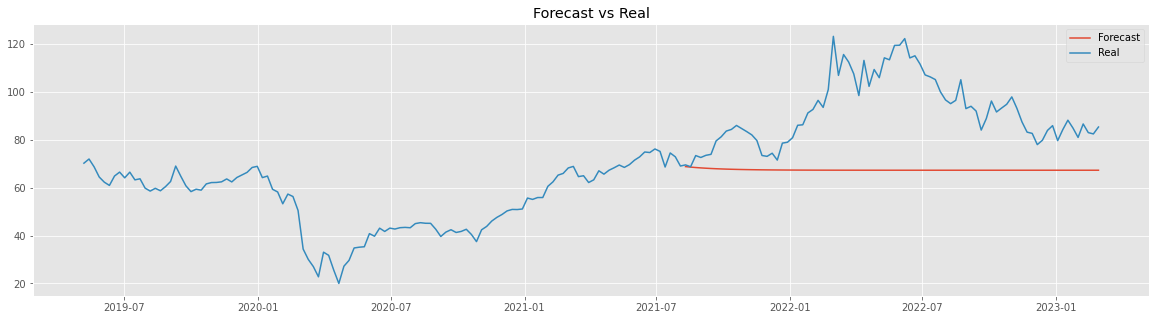

In [146]:
plot(auto_pred, brent.tail(200))
